In [1]:
# -*- coding: utf-8 -*-
"""
Binary‑MNIST (6 vs 8) — Binder‑cumulant analysis (precision ≥ 5 dp)
==================================================================
* dataset     : MNIST digits **6 & 8**
* grid        : σ_w² ∈ [1,4]  step 0.1  |  depth L ∈ {10,30,…,290}
* network     : width 512, tanh, σ_b² = 0.05
* training    : quick‑train 2 000 SGD steps — lr = 1e‑3 (L≤200) else 1e‑4
* observables :
    m    = ⟨ sign(logit0 − logit1) ⟩                  # order parameter
    U    = 1 − ⟨m⁴⟩ / [3 ⟨m²⟩²]                        # Binder cumulant
    acc  = test accuracy
* outputs     :
    1. heatmap of m̄ (ensemble‑average)
    2. heatmap of accuracȳ
    3. Binder‑cumulant intersection plot + critical‑exponent fit (ν)
    4. phase_results.csv — one row per (L, σ_w², seed) with values
      ( loss, m, Binder, accuracy ) each **formatted to 5 decimal places**
"""
import math, itertools, csv, json, numpy as np, torch, matplotlib.pyplot as plt
import torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from tqdm.auto import tqdm

In [3]:
# ╭─────────────────────────── Device ────────────────────────────╮
DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", DEV)

# ╭─────────────────────────── Data (6 vs 8) ─────────────────────╮
TFM = transforms.ToTensor()
train_raw = datasets.MNIST("./data", train=True , download=True, transform=TFM)
test_raw  = datasets.MNIST("./data", train=False, download=True, transform=TFM)

mask_train = (train_raw.targets == 6) | (train_raw.targets == 8)
mask_test  = (test_raw.targets  == 6) | (test_raw.targets  == 8)
train_raw.data, train_raw.targets = train_raw.data[mask_train], train_raw.targets[mask_train]
test_raw .data, test_raw .targets = test_raw .data [mask_test ], test_raw .targets [mask_test ]

# remap labels: 6→0, 8→1
train_raw.targets = (train_raw.targets == 8).long()
test_raw .targets = (test_raw .targets == 8).long()

train_ld = torch.utils.data.DataLoader(train_raw, batch_size=128, shuffle=True)
N_test   = len(test_raw)

test_x,_ = next(iter(torch.utils.data.DataLoader(test_raw, batch_size=N_test)))
TEST_X   = test_x.to(DEV)
TEST_Y   = test_raw.targets.to(DEV)
print(f"train={len(train_raw)}, test={N_test}")

device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 36.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 999kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.50MB/s]


train=11769, test=1932


In [4]:
# ─────────────────── Balance the two labels (6→0, 8→1) ───────────────────
from torch.utils.data import Subset
import numpy as np

def balance_dataset(dataset, seed: int = 0):
    """
    Randomly down-sample the majority class so that both classes have equal sample counts.
    
    Parameters
    ----------
    dataset : torchvision.datasets.MNIST (or any dataset with .targets)
        The original dataset to balance.
    seed : int
        Random seed for reproducibility.
    
    Returns
    -------
    torch.utils.data.Subset
        A subset containing only the selected, balanced indices.
    """
    rng = np.random.default_rng(seed)

    labels = dataset.targets.numpy()
    idx_cls0 = np.where(labels == 0)[0]
    idx_cls1 = np.where(labels == 1)[0]

    n0, n1 = len(idx_cls0), len(idx_cls1)
    if n0 == n1:
        print("Dataset already balanced:", n0, n1)
        return dataset

    # Determine target sample count as the size of the smaller class
    n_target = min(n0, n1)
    # Randomly sample without replacement
    idx_cls0 = rng.choice(idx_cls0, n_target, replace=False)
    idx_cls1 = rng.choice(idx_cls1, n_target, replace=False)
    # Concatenate and shuffle the kept indices
    keep_idx = np.concatenate([idx_cls0, idx_cls1])
    rng.shuffle(keep_idx)

    print(f"Balanced dataset: {n_target} vs {n_target} = {len(keep_idx)} samples")
    return Subset(dataset, keep_idx)

# Balance train / test sets
train_bal = balance_dataset(train_raw, seed=42)
test_bal  = balance_dataset(test_raw , seed=42)

# Re-create DataLoader and test tensors
train_ld = torch.utils.data.DataLoader(train_bal, batch_size=128, shuffle=True)

N_test   = len(test_bal)
test_x, test_y = next(iter(
    torch.utils.data.DataLoader(test_bal, batch_size=N_test)
))
TEST_X   = test_x.to(DEV)
TEST_Y   = test_y.to(DEV)

print(f"Balanced train={len(train_bal)}, balanced test={len(test_bal)}")

balanced dataset: 5851 vs 5851 = 11702 samples
balanced dataset: 958 vs 958 = 1916 samples
balanced train=11702, balanced test=1916


In [23]:
# ╭─────────────────────────── Model ─────────────────────────────╮
class FC(nn.Module):
    def __init__(self, depth: int, width: int, sig_w: float, sig_b2: float = 0.05):
        super().__init__(); layers = []
        scale_in = sig_w / math.sqrt(784)
        inp = nn.Linear(784, width)
        nn.init.normal_(inp.weight, 0, scale_in)
        nn.init.normal_(inp.bias,   0, math.sqrt(sig_b2))
        layers += [inp, nn.Tanh()]

        scale = sig_w / math.sqrt(width)
        for _ in range(depth - 1):
            h = nn.Linear(width, width)
            nn.init.normal_(h.weight, 0, scale)
            nn.init.normal_(h.bias,   0, math.sqrt(sig_b2))
            layers += [h, nn.Tanh()]

        out = nn.Linear(width, 2)
        nn.init.normal_(out.weight, 0, scale)
        nn.init.normal_(out.bias,   0, math.sqrt(sig_b2))
        layers.append(out)
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

# ╭─────────────────────────── Quick‑train ───────────────────────╮
@torch.no_grad()
def _loss_on_batch(net, x, y):
    return nn.functional.cross_entropy(net(x), y).item()

def quick_train(net: nn.Module, steps: int, lr: float):
    net.train(); opt = optim.SGD(net.parameters(), lr=lr); loss_fn = nn.CrossEntropyLoss()
    it = itertools.cycle(train_ld)
    last_loss = None
    for _ in range(steps):
        x, y = next(it); x, y = x.to(DEV), y.to(DEV)
        opt.zero_grad(); loss = loss_fn(net(x), y); loss.backward(); opt.step()
        last_loss = loss.item()
    return last_loss

# ╭─────────────────────────── Observables ───────────────────────╮
@torch.no_grad()
def observables(net: nn.Module):
    logits = net(TEST_X)
    spin   = torch.sign(logits[:, 1] - logits[:, 0])      # +1 for digit‑8
    m      = spin.mean().item()                           # order parameter
    acc    = (logits.argmax(1) == TEST_Y).float().mean().item()
    return m, acc

# ╭─────────────────────────── Parameter grid ────────────────────╮
DEPTHS = np.arange(20, 210, 10)        # 10,30,…,290
SIGMAS = np.arange(1.0, 2.01, 0.1)
SEEDS  = 4                            # ensemble size per (L, σ_w²)
EPS    = 1e-12
M_grid      = np.zeros((len(DEPTHS), len(SIGMAS)))      # ⟨m⟩
Mabs_grid   = np.zeros((len(DEPTHS), len(SIGMAS)))
Binder_grid = np.zeros_like(M_grid)                     # U
ACC_grid    = np.zeros_like(M_grid)                     # ⟨acc⟩

FIELDNAMES = [
    "seed", "depth", "sigma_w2",
    "loss",            
    "m",              
    "m_abs",           
    "accuracy",        
    "binder"          
]

csv_rows = []

for i_L, L in enumerate(tqdm(DEPTHS, desc="depth")):
    lr = 1e-3 if L <= 200 else 1e-4
    for j_S, sigma in enumerate(SIGMAS):
        m_samples, acc_samples = [], []
        for seed in range(SEEDS):
            torch.manual_seed(seed)
            net = FC(L, 512, sigma).to(DEV)
            last_loss = quick_train(net, 2000, lr)
            m, acc = observables(net.eval())
            csv_rows.append({
                "seed":     seed,
                "depth":    L,
                "sigma_w2": f"{sigma**2:.5f}",
                "loss":     f"{last_loss:.5f}",
                "m":        f"{m:.5f}",
                "m_abs":    f"{abs(m):.5f}",
                "accuracy": f"{acc:.5f}",
                "binder":   None          
            })

            m_samples.append(m)
            acc_samples.append(acc)
            
        # ensemble averages & Binder
        m_samples = np.array(m_samples)
        m2 = np.mean(m_samples ** 2)
        m4 = np.mean(m_samples ** 4)
        # ─── Robust Binder calculation ───
        if m2 < EPS:
             U = 0.0                 # Gaussian regime ⇒ U → 0
        else:
             U_raw = 1.0 - m4 / (3.0 * m2 * m2)
             U = 0.0 if not np.isfinite(U_raw) else U_raw  
        
        U_str = f"{U:.5f}"
        for row in csv_rows[-SEEDS:]:
            row["binder"] = U_str
        
        M_grid[i_L, j_S]      = m_samples.mean()
        Binder_grid[i_L, j_S] = U
        ACC_grid[i_L, j_S]    = np.mean(acc_samples)
        U_str = f"{U:.5f}"
        for row in csv_rows[-SEEDS:]:
            row["binder"] = U_str
        m_samples = np.asarray(m_samples)

        M_grid[i_L, j_S]      = m_samples.mean()          # 〈m〉  
        Mabs_grid[i_L, j_S]   = np.mean(np.abs(m_samples))# 〈|m|〉 
# ╭─────────────────────────── Save CSV ──────────────────────────╮
with open("phase_results.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=FIELDNAMES)
    writer.writeheader()
    writer.writerows(csv_rows)
print("CSV saved → phase_results.csv")

depth:   0%|          | 0/19 [00:00<?, ?it/s]

CSV saved → phase_results.csv


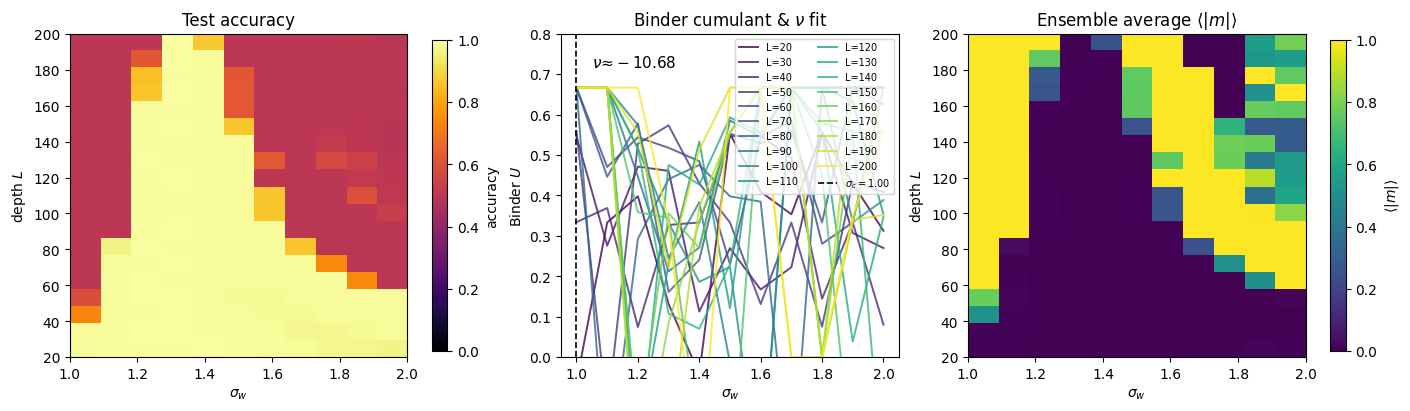

In [24]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(14, 4),  
    constrained_layout=True             
)

# ========= 1. Test accuracy =========
ax = axes[0]
im_acc = ax.imshow(
    ACC_grid, origin="lower", aspect="auto",
    extent=[SIGMAS.min(), SIGMAS.max(), DEPTHS.min(), DEPTHS.max()],
    cmap="inferno", vmin=0, vmax=1
)
ax.set_title("Test accuracy")
ax.set_xlabel("$σ_w$");  ax.set_ylabel("depth $L$")
fig.colorbar(im_acc, ax=ax, fraction=0.046, pad=0.04, label="accuracy")

# ========= 2. Binder cumulant =========
ax = axes[1]
ax.set_title("Binder cumulant & $ν$ fit")
colors = plt.cm.viridis(np.linspace(0, 1, len(DEPTHS)))

#  U_L(σ_w)
for i_L, L in enumerate(DEPTHS):
    ax.plot(SIGMAS, Binder_grid[i_L], lw=1.4,
            color=colors[i_L], alpha=0.8, label=f"L={L}")

#  σ_c
U_var    = np.nanvar(Binder_grid, axis=0)
crit_idx = np.argmin(U_var)
sigma_c  = SIGMAS[crit_idx]
ax.axvline(sigma_c, ls="--", lw=1.2, c="k", label=fr"$σ_c={sigma_c:.2f}$")

# Critical exponent ν：|dU/dσ|_max ∝ L^{1/ν}
deriv_max = []
for i_L in range(len(DEPTHS)):
    dU = np.gradient(Binder_grid[i_L], SIGMAS, edge_order=2)
    deriv_max.append(np.nanmax(np.abs(dU)))
coef, _ = np.polyfit(np.log(DEPTHS), np.log(deriv_max), 1)
nu_est = 1.0 / coef
ax.text(SIGMAS[0] + 0.05, 0.75, fr"$ν≈{nu_est:.2f}$",
        fontsize=11, va="top")
ax.set_xlabel("$σ_w$");  ax.set_ylabel("Binder $U$")
ax.set_ylim(0, 0.8)
ax.legend(fontsize=7, ncol=2, loc="upper right")

# ========= 3. ⟨|m|⟩ heat-map =========
ax = axes[2]
im_m = ax.imshow(
    Mabs_grid, origin="lower", aspect="auto",
    extent=[SIGMAS.min(), SIGMAS.max(), DEPTHS.min(), DEPTHS.max()],
    cmap="viridis", vmin=0, vmax=1
)
ax.set_title(r"Ensemble average $\langle|m|\rangle$")
ax.set_xlabel("$σ_w$");  ax.set_ylabel("depth $L$")
fig.colorbar(im_m, ax=ax, fraction=0.046, pad=0.04, label=r"$\langle|m|\rangle$")

plt.show()
